# Ch. 11 - Evaluating and deploying the model
In chapter 10 we have learned a lot of new tricks and tools to build neural networks that can deal with stuructured data such as the bank marketing dataset.
In this chapter we will take a look at model evaluation and the steps that are nessecary till we can deploy out model in the real world.

## Loading the model
In the last chapter we have experimented with different tools for our neural network. To spare the step in this chapter, a model has been saved as an H5 file already. It was created using the tools from the last chapter.

In [1]:
import keras
from keras.models import load_model

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [3]:
model = load_model('./support_files/Ch11_model.h5')

## Loading the data
We have also seen already how to split data into train, dev and test sets. To save repetition, the data from used in the last chapter has been saved and can now be loaded using numpys [load function](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.load.html#numpy.load). Note that this directly creates a numpy array and not a pandas dataframe as it did when we loaded the data from csv.

In [4]:
import numpy as np

In [5]:
X_dev, y_dev = np.load('./support_files/Ch_11_X_dev.npy'), np.load('./support_files/Ch_11_y_dev.npy')
X_test, y_test = np.load('./support_files/Ch_11_X_test.npy'), np.load('./support_files/Ch_11_y_test.npy')

## Evaluating on the evaluation criteria
In the last chapter, we looked at the accuracy and loss of the model. Accuracy is a good proxy for our actual evaluation metric but it is not exactly the same. Recall that our evaluation metric is the profit made per thousand calls and can be defined as

$$ profit = \frac{100 * TP - 40 * FP}{TP + FP} * 1000 $$

Where $TP$ are true positives, where our model predicted the customer would subscribe and the customer actually did subscribe and $FP$ are false positives where the model predicted the customer would subscribe but the customer did not subcribe.

In python we can define the profit function like this:

In [6]:
def profit_per_thousand_calls(tp,fp):
    profit = (100*tp - 40*fp) /(tp + fp) * 1000
    return profit

Before we make statements on the profit we need predictions from the model. Note that our model does not output weather a customer will buy or not but only the _probability_ of a purchase. So we need to convert those probabilities into predictions. We do this by setting a threshold and assigning all probabilities above this threshold to positive and all below to negative. In this case the threshold is 50% meaning that for all customers with a higher than 50% predicted probability of a purchase we expect a purchase and call them. 

In [7]:
# Get the probabilities
predictions = model.predict(X_dev)

In [8]:
# Turn the probabilities into definite predictions
predictions[predictions >= 0.5] = 1
predictions[predictions < 0.5] = 0

To calculate the profit we need the true and false positives. A handy way to calculate true and positives as well as true and false negatives is sklearns [confusion matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). A confusion matrix is a matrix that counts how the model 'confuses' or correctly classifies examples. 

||Predicted Negative|Predicted Positive|
|-----------------|
|**Actual Negative**|TN|FP|
|**Actual Positve**|FN|TP|

We can get the values out of the matrix by unrolling it with the numpy [ravel function](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ravel.html).

In [9]:
from sklearn.metrics import confusion_matrix

In [10]:
# calculate confusion matrix
cm = confusion_matrix(y_pred=predictions,y_true=y_dev)
# Unroll confusion matrix
tn, fp, fn, tp = cm.ravel()

Now we can calculate the profit of our campaign using the profit function defined above.

In [11]:
profit_per_thousand_calls(tp,fp)

72231.404958677682

The profit predicted on the test set looks quite well \$72,231.40! An increase of more than \$42,000 over the base case. The Portuguese bank will be quite happy that we boosted the profit of their campaign. However, before shipping the model into all call centers, we should give the confusion matrix a closer look, as there is more information to be gained. We can plot it with a seaborn [heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

In [12]:
# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

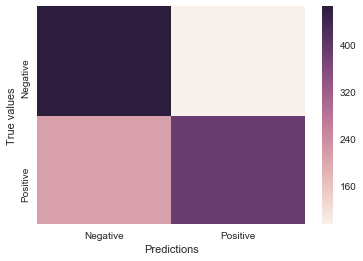

In [13]:
# Create heatmap
ax = sns.heatmap(cm,xticklabels=['Negative','Positive'],yticklabels=['Negative','Positive'])
# Add axis labels
ax.set(xlabel='Predictions', ylabel='True values')
# Render heatmap
plt.show()

## Interpreting the confusion matrix
As you can see, the model correctly classifies the majority of cases. However, it seems like it is a bit pessimistic. See how there are more false negatives than false positives. This however is not a bad thing as false positives cost money and false negatives do not. Confusion matrices can be very useful especially when you are working with more than two classes. It might well be that your classifier confuses two categories very often while it does well on the rest. Then it is often a good idea to go back and either engineer features or add data that will help distinguish the two classes in question. A confusion matrix is a good way to get an overview about what is going on and whether there is a systematic error.

## Experimenting with thresholds
As false positives cost money, we should think about at which threshold we should call customers. 50% probability seems like an a bit arbitrary value, so it is worth investigating the performance under different thresholds. To this end, we will calculate the expected profit over an array of thresholds from 0 to 1.

In [14]:
# Get the probabilities
predictions = model.predict(X_dev)

In [15]:
# Create array of thresholds ranging from 0 to 1 in 0.01 steps
thesholds = np.arange(0,1,0.01)

In [16]:
# Create empty array holding profits for all thresholds
profits = []
# Loop over possible thresholds
for t in thesholds:
    # Create a copy of the predicted probabilities
    pred = predictions.copy()
    # Turn the probabilities into definite predictions
    # This time using the threshold
    pred[predictions >= t] = 1
    pred[predictions < t] = 0
    # Get confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_pred=pred,y_true=y_dev).ravel()
    # At some point there might not be any positives anymore, so we should stop there
    if ((tp + fp ) == 0):
        print('No more positives at threshold:',t)
        break # Ends the loop
    # Calculate the profit and add it to the list.
    profits.append(profit_per_thousand_calls(tp,fp))

No more positives at threshold: 0.95


We can now plot the expected profits:

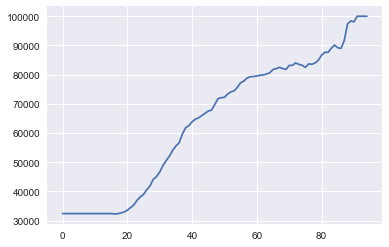

In [17]:
plt.plot(profits)

Naturally the expected profit per thousand calls rises the higher we set the probability of a yes before we call. It reaches the optimum case of \$100,000 at a threshold of 0.91 and at a threshold of 0.95 there are no positives any more. Of course simply evaluating the profit on a per thousand calls base and not factoring in that many customers who might have bought did not get called. Whether or not this is a problem depends on of many potential calls there are. If we have a limited database of phone numbers we might want to set the threshold lower or we would make only very few calls. In practice, we therefore usually sort customers by predicted likelihood of a subscription and then call the ones with the best chances first. If we have many potential customers we can call only the ones with very good chances, otherwise we will have to make do with the lower rungs as well.

## Checking for systematic bias
Before we roll out the model we should make sure that does not systematically discriminate against a certain group of people. While a model that systematically does not call a minority is usually no drama, a model that systematically disapproves loans to that minority is. Machine learning models amplify biases in the data. Since they find correlations and patterns, they are likely to overreact to them a little bit. We can imagine this like setting up rules of thumb. We know that a rule of thumb is not entirely correct when we use it ourselves but it is better than just a random choice so we use it in our day to day life a lot. The same goes for models which amplify patterns and use them like rules of thumb, even if the reality is less clear.

When checking for hidden biases you usually would check for data your model should not discriminate on, such as gender or skin color. These variables should not be trained on in the first place but there might be traces of them in the data since gender might correlate with the job status for example. There are two kinds of biases our model could exhibit:
- A deviation from the data: E.g. our data reflects no lower subscription likelihood for a certain minority but the model discriminates against it anyway.
- A bias reflected in the data: E.g. our data is skewed but we know that the minority is not more or less likely to subscribe or do not want our model to react to it.

To deal with the first kind, we can compare the average probabilities the model assigns to one group against the actual probabilities of that group. Let's say we want to check whether our model discriminates against young people. We know from chapter 9 that young people are actually a bit more likely to subscribe and there are good reasons for it as they have more time and likely do not have a long term deposit yet. But perhaps our model is overly optimistic about them:

In [18]:
# 'age_young' is the 22nd column in the numpy array so we can get the data for all young customers like this:
X_dev_young = X_dev[X_dev[:,22]==1]
# The indices in the data and the labels match so we can get the labels for the young people like this:
y_dev_young = y_dev[X_dev[:,22]==1]

In [19]:
# Now we can calculate the actual probability that a young person subscribes
y_dev_young.mean()

0.53893442622950816

In [20]:
# And the predicted probability that a young person subcribes
young_pred = model.predict(X_dev_young)
young_pred.mean()

0.53436881

It looks like the model does not exhibit any biases about young people. This is the outcome we hoped for so we can proceed.

The second case of undesired biases that get picked up by the model is more pervasive and often more difficult to deal with. A classic example comes from HR: A company has kept good records about promotions and wants to train a model on it. However, the managers that made those promotions where not gender neutral and did promote fewer women. If we train on this data we should expect that the model will install a firm glass ceiling.

As an example we will check whether our model discriminates based on gender. The gender data is not part of the original UCI dataset and was generated for the purpose of giving an example.

In [22]:
# Load the gender data
# It is encoded so that 1 = male and 0 = female
gender = np.load('./support_files/Ch11_gender.npy')

In [23]:
# Get the subset of males in our dev data
X_dev_male = X_dev[gender[:,0] == 1]
y_dev_male = y_dev[gender[:,0] == 1]

In [24]:
# Calculate probability of male subscription to check for bias in data
y_dev_male.mean()

0.5137457044673539

It seems as males are in fact a little bit more likely to subscribe although the effect is quite small. We do not want our model to discriminate based on gender which is why gender was not included in the training set. But perhaps the model did pick up on it and it might even have over amplified the effect.

In [25]:
# Get predicted probabailites
male_pred = model.predict(X_dev_male)
# Calculate mean probability
male_pred.mean()

0.49400932

It seems as the model did not pick up on gender bias. The probability for males is close to 50%, as it is for the entire dataset.

Checking for hidden biases is tricky business and a few simple statistics seldom do the trick. The biggest danger of hidden biases are that they are hidden. It is hard to anticipate them in advance and check for them. This is why it is important to give people who interact with the model a voice. They might spot them because they get confronted with them.

## Testing on new data
Now that we are reasonable sure we have a good model, we need to test it on new data before we ship it. Test data should be hold out data that is not touched during the training or evaluation process. Because if we change our model based on the evaluation we run the risk of fitting our model to the data we evaluate on. Therefore it is important to have a 'clean' dataset for testing. We will run the profit evaluation above again, this time on the test set:

In [26]:
# First check accuracy and loss
model.evaluate(x=X_test,y=y_test)

1160/1160 [==============================] - 0s     


[0.5686384371642409, 0.74310344827586206]

Accuracy and loss look good. There seems to be little difference to the outcomes of our dev set.

In [27]:
# Get the probabilities now from the test set
predictions = model.predict(X_test)

In [28]:
# Calculate profit with 50% threshold
# Turn the probabilities into definite predictions
predictions[predictions >= 0.5] = 1
predictions[predictions < 0.5] = 0

In [29]:
# calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_pred=predictions,y_true=y_test).ravel()

In [30]:
profit_per_thousand_calls(tp,fp)

70346.232179226063

The profit at a 50% threshold is a bit lower than on the dev set but not substantially. Based on the test set it looks like the model performs just as well on unseen data as on the dev set. A good way to ensure that the model is actually working is to deploy it silently.

## Deploying the model
The best way of deploying the model into actual usage depends strongly on the application. Some tasks might require big models and lot's of computing power while others can run on much less. Technical details of deployment also depend on the infrastructure that the client is using, which operating system the servers run on, how the databases work, which hardware is available, and so on. The specifications of deployment should be specified before developing the model and are often part of the evaluation metric. When deployment time rolls around, the model should be ready for its environment. So here we will focus on just a few roll out strategies that have little to do with the technical deployment:

### Silent deployment
A famous example of silent deployment is the Tesla autopilot. To develop and test the system, all Tesla cars where outfitted with the autopilot software which was constantly running even when the user did not activate autopilot. The model constantly made predictions on how the model should drive and these predictions along with sensory data and information about how the user actually did drive were sent back to Tesla. The engineers on the model could check where the models predictions differed from actual behavior and debug the model. They were also getting a lot of information about how well their model worked, how fast it ran and so on. It is nearly as if the model had actually been deployed but with much less risk. In our case for example the model could silently predict which customers will subscribe. This data could be collected alongside the actual outcomes of the call while we keep operating the call center as normal.

### A/B Testing
After testing in silent mode, the next step is to roll out the model for some, but not all users. We treat the unaffected users as control group and measure the effects. For example we could let some call center agents make calls as advised by the model while others stick with making random calls. We could then track which group is more successful, and how much they like working with the model. Preferably if legally and ethically possible, the users do not know whether they are working with the model or not to avoid distortions. In our case this is tricky however. Call center agents often earn a commission on sales, so if we are tampering with their chances of success, we are tampering with their earnings. Doing this without telling them is unethical and probably also illegal. A way around this could be to rotate the deployment of the model and to tell agents at end of the week which days they worked with the model and which days without.

## Monitoring a model in deployment
After the model has been rolled out it is important to keep taps on it. Models and their predictions should not be secret and people should have the ability to challenge them. This will help prevent unfair treatment and can greatly improve the success of the model. Users 'on the front-line' might have better insight into the workings of the model as the developers who can only follow a birds eye view. Here are few tips that can help monitor the deployment:

- Keep a visible bug reporting button next to the models output ![feedback button](./assets/feedback_button.jpg)

- Make it easy to mark what is wrong ![spot errors](./assets/spot_errors.png)

- Log your performance metrics (accuracy, loss, profit) on new data as it comes in (Now-Testing)

- Experiment and A/B test with other models, train on new data as it comes in and Back-Test it on old data.

## Summary
In this chapter you have seen how to evaluate a model and take it to deployment. There are a lot more technical details we glossed over but no established standards are developed yet. If the technical details are relevant to you, consider reading [this series on deploying models with TensorFlow](https://medium.com/towards-data-science/how-to-deploy-machine-learning-models-with-tensorflow-part-1-make-your-model-ready-for-serving-776a14ec3198) or [this discussion on the machine learning subreddit](https://www.reddit.com/r/MachineLearning/comments/6tu9gu/what_is_the_process_of_deploying_machine_learning/).